# 1. Importing Libraries

Just importing important libraries

In [1]:
# Important libraries
import numpy as np
import nengo
import nengo_dl
import pandas as pd
from nengo.ensemble import Ensemble
from nengo.connection import Connection
from nengo.node import Node
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import gaussian_filter1d

c:\Users\kapj_\OneDrive\Documents\GitHub\BCI-Signal-Decoding\env\lib\site-packages\nengo_dl\version.py:58: UserWarning: This version of NengoDL has not been tested with your Nengo version (4.0.0). The latest fully supported version is 3.2.0.
  warnings.warn(warnstr)


# 2. Loading Data

### 2.1 Basic File Properties

Make sure to save the entire raw data in 'Data Extration'.
There should be four files: MM_S1_raw.csv, MT_S1_raw.csv, MT_S2_raw.csv, MT_S3_raw.csv, 

In [2]:
# Change 'monkey' variable to the desired monkey dataset: MM_S1, MT_S1, MT_S2, MT_S3
monkey = "MM_S1"

# Datapath to get the raw data file (Stored in DataExtraction)
datafile_path = r"..\\..\\Data Extraction\\"+monkey+"_raw.csv"

### 2.2 Importing the dataset

Get the activity matrix and kinematic data from the files

In [3]:
data_df = pd.read_csv(datafile_path)
headers = data_df.columns.tolist()
n_neurons = sum("Neuron" in string for string in headers)
print(n_neurons)


94


### 2.3 Preparing the data

In [4]:
# Getting the train activity and kinematic matrix
activity_matrix = data_df.loc[:, 'Neuron1':f'Neuron{n_neurons}']
kinem_matrix = data_df.loc[:, 'x_acceleration':'y_acceleration']

# Transpose data to ensure that dimensions are correct for decoder values
tranposed_activity_matrix = activity_matrix.transpose()
tranposed_kinem_matrix = kinem_matrix.transpose()

A = tranposed_activity_matrix.to_numpy()  # n_neurons x n_timepoints
Y = tranposed_kinem_matrix.to_numpy()    # n_kinematics x n_timepoints

# Autoencoder

In [5]:
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import torch

# Convert to PyTorch tensor
spike_data = np.transpose(A)
spike_data_tensor = torch.FloatTensor(spike_data)

# Train-test split (80% train, 20% test)
train_data, val_data = train_test_split(spike_data_tensor, test_size=0.2, random_state=42)

# Dataloaders (for batch processing)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False)


In [6]:
# Define Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.Sigmoid()  # Sigmoid for binary outputs
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
# Initialize model, loss, optimizer
input_dim = spike_data.shape[1]  # 49 neurons
encoding_dim = 10  # Compressed size
model = Autoencoder(input_dim, encoding_dim)
criterion = nn.BCELoss()  # Binary Cross Entropy loss for binary spike data
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with validation
num_epochs = 4
for epoch in range(num_epochs):
    model.train()  # Training mode
    train_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Compute validation loss
    model.eval()  # Evaluation mode (disables dropout, etc.)
    val_loss = 0
    acc = 0
    start = False
    with torch.no_grad():
        for batch in val_loader:
            output = model(batch)
            val_loss += criterion(output, batch).item()
            acc_ = 0
            for j in range(len(batch)):
            # if start == False:
            #     start = True
                input_sample = batch[j].numpy()
                output_sample = (output[j] > 0.5).numpy().astype(int)
                acc_ += (input_sample == output_sample).sum() / input_dim
            acc += acc_/len(batch)

    # Print loss per epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}"
          f" Acc: {acc/len(val_loader):.4f}")

Epoch [1/4], Train Loss: 0.0122, Val Loss: 0.0023 Acc: 0.9993
Epoch [2/4], Train Loss: 0.0021, Val Loss: 0.0020 Acc: 0.9994
Epoch [3/4], Train Loss: 0.0019, Val Loss: 0.0019 Acc: 0.9994
Epoch [4/4], Train Loss: 0.0018, Val Loss: 0.0018 Acc: 0.9994


In [8]:
from torch.utils.data import DataLoader, TensorDataset

# Create a DataLoader for batch processing
dataloader = DataLoader(spike_data_tensor, batch_size=32, shuffle=False)

# Pre-trained model (already loaded)
model.eval()  # Set to evaluation mode

# List to store predictions
predictions = []

# Step 4: Loop through batches and predict
with torch.no_grad():  # No need to compute gradients during inference
    for batch in dataloader:
        # Get the model prediction (output shape: (1, num_neurons, time_bins))
        
        output_batch = model(batch)  

        # Round to binary (0 or 1)
        binary_output = torch.round(output_batch)

        predictions.append(binary_output.numpy()) # 3311, 32, 94


In [9]:
torch.save(model.state_dict(), 'model.pth')

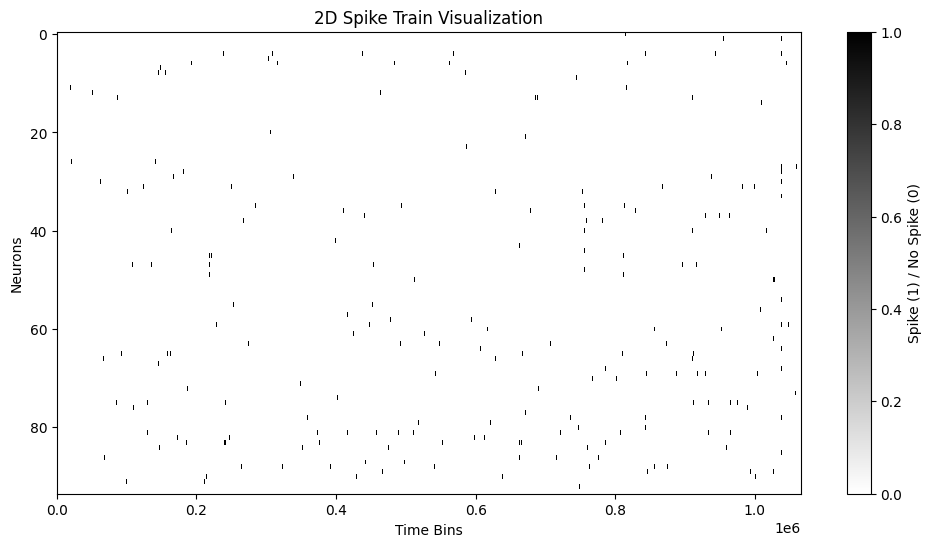

280423.0


In [10]:
# Combine all batches into one tensor
predictions_cat = np.concatenate((predictions), axis=0)

# # Plotting the spike train
plt.figure(figsize=(12, 6))
plt.imshow(np.transpose(predictions_cat), cmap='binary', aspect='auto', interpolation='none')
plt.colorbar(label="Spike (1) / No Spike (0)")
plt.xlabel('Time Bins')
plt.ylabel('Neurons')
plt.title('2D Spike Train Visualization')
plt.show()
print(np.sum(predictions_cat))

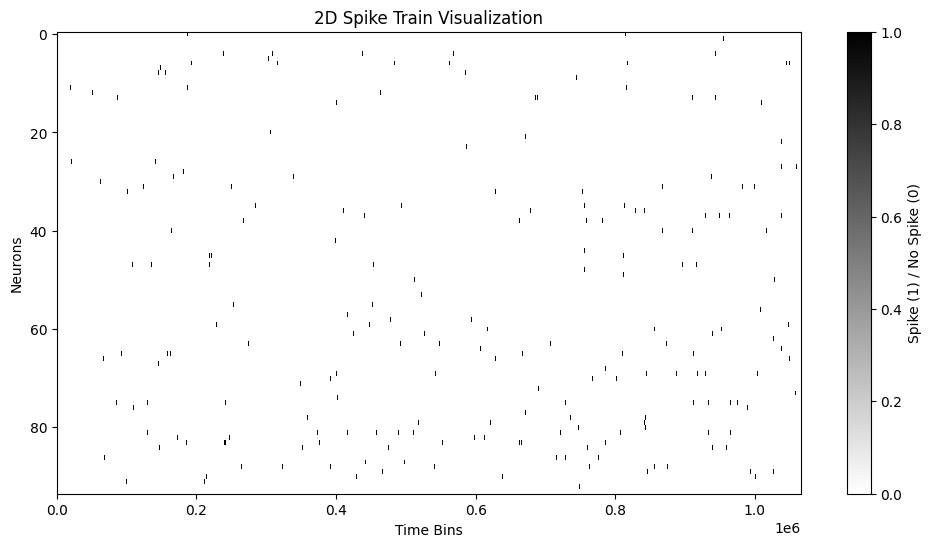

293585


In [11]:
# # Plotting the spike train
plt.figure(figsize=(12, 6))
plt.imshow(np.transpose(spike_data), cmap='binary', aspect='auto', interpolation='none')
plt.colorbar(label="Spike (1) / No Spike (0)")
plt.xlabel('Time Bins')
plt.ylabel('Neurons')
plt.title('2D Spike Train Visualization')
plt.show()
print(np.sum(spike_data))

# 3. Building the Minimal Effort Learning Model

In [15]:
# Load model
model = Autoencoder(n_neurons, 10) # we do not specify ``weights``, i.e. create untrained model
model.load_state_dict(torch.load('model.pth', weights_only=True))
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=94, out_features=10, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=94, bias=True)
    (1): Sigmoid()
  )
)

In [17]:
temp_spikes = np.transpose(A)
model.eval()

reduced_spikes = []
with torch.no_grad():
    for i in temp_spikes:
        out = model.encoder(torch.FloatTensor(i))
        reduced_spikes.append(out.numpy())

### 3.1 Setting up and Adjusting Model Parameters

In [20]:
Y[0] = gaussian_filter1d(Y[0], sigma=10)
Y[1] = gaussian_filter1d(Y[1], sigma=10)

# Getting the input and output data for the model
# spikes = A
reduced_spikes = np.transpose(reduced_spikes)

scaler = np.max(Y)
kin_data = Y / scaler

# Model information
dt = 0.001
dti = 1/dt
# spikes = spikes*dti

# Parameters to change
n_ensemble_neurons = 5000
ensemble_radius = 2
ensemble_synapse = 0.025
probe_synapse = 0.01

running_time = 150 # How long the model should run for
training_time = 0.8*running_time # WHen does the model stop learning

### 3.2 Implementing the Nengo Model

The image below is a visualization of the MELM model
![Architecture](MELM_architecture-A.png)

In [21]:
from LMU_Stack import LMUStack
# Nengo Network Using Recorded Spikes as Input

np.random.seed(0)
with nengo.Network() as model:

    # Input signal
    input_node = nengo.Node(lambda t: reduced_spikes[:,int(t / dt) - 1])

    lmu_stack = LMUStack(10, order = 4, window = 2, dt=dt)

    # Connect first ensemble to output ensemble
    lmu_stack_ensemble = nengo.Ensemble(n_neurons=40*50, dimensions=40, radius = 7)
    lmu_stack_connect = nengo.Connection(lmu_stack.output, lmu_stack_ensemble)


    output_ensemble = nengo.Ensemble(n_neurons=2*50, dimensions=2, radius = ensemble_radius)
    learn_conn = nengo.Connection(lmu_stack_ensemble, output_ensemble,  function=lambda x: [0, 0], learning_rule_type=nengo.PES(learning_rate=2e-4))


    # Connect output to error
    error_ensemble = nengo.Ensemble(n_neurons=2*50, dimensions=2, radius = ensemble_radius)
    nengo.Connection(output_ensemble, error_ensemble)

    # Connect error to the learning connection
    nengo.Connection(error_ensemble, learn_conn.learning_rule)

    # Get ground truth value
    truth_node = nengo.Node(lambda t: kin_data[:,int(t/dt) -1])
    nengo.Connection(truth_node, error_ensemble, transform=-1)

    # Probe for graphing
    p_post = nengo.Probe(output_ensemble, synapse=probe_synapse)

    # Stop learning after 80% of the running time has passed
    stop_learning = nengo.Node(output=lambda t: t >= training_time)
    nengo.Connection(
        stop_learning, error_ensemble.neurons, transform=-20 * np.ones((error_ensemble.n_neurons, 1))
    )

### 3.3 Running the Model and Plotting the Output

Build finished in 0:00:02.                                                      
Simulation finished in 0:01:22.                                                 


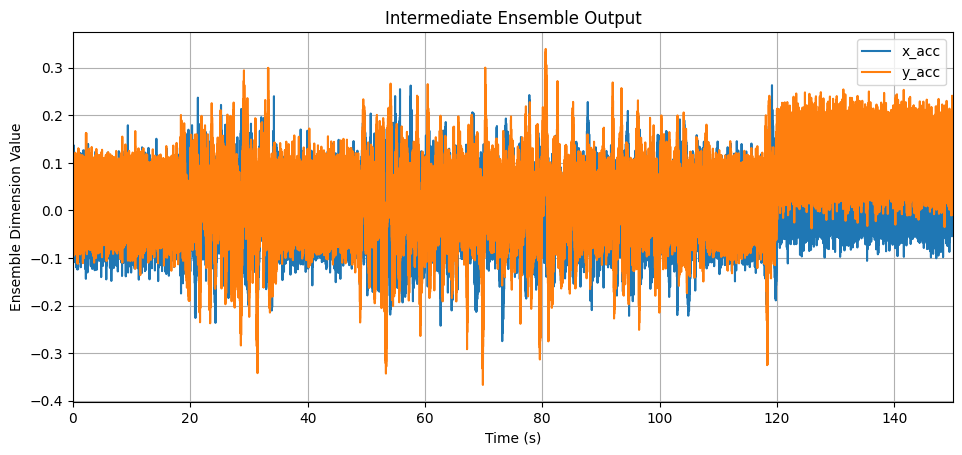

In [23]:
# with nengo_dl.Simulator(model, dt=dt, seed=0, device="/gpu:0") as sim:
with nengo.Simulator(model, dt=dt, seed=0) as sim:
    sim.run(running_time)

fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_post])
pl.set_title("Intermediate Ensemble Output")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["x_acc", "y_acc"])
pl.grid()

# 4. Plotting and Comparing the Outputs

### 4.1 Plotting Predicted vs Actual Acceleration

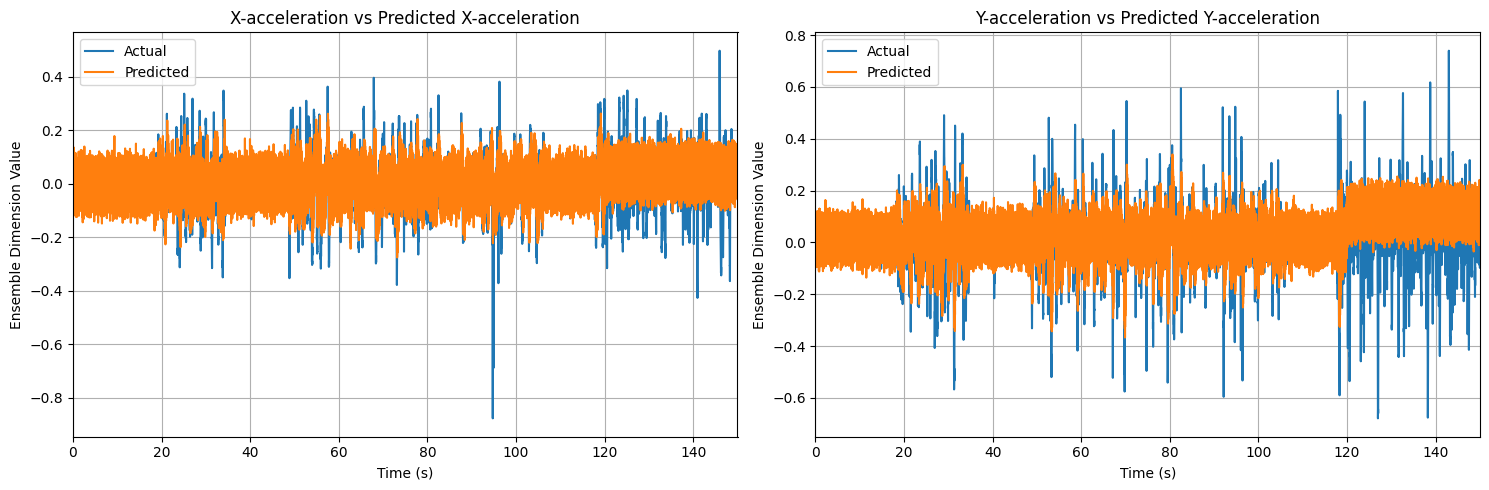

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(sim.trange(), kin_data[0, 0:len(sim.trange())])
ax1.plot(sim.trange(), sim.data[p_post][:, 0])
ax1.set_title("X-acceleration vs Predicted X-acceleration")
ax1.set_xlim((0,np.max(sim.trange())))
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Ensemble Dimension Value")
ax1.legend(["Actual", "Predicted"])
ax1.grid()

ax2.plot(sim.trange(), kin_data[1, 0:len(sim.trange())])
ax2.plot(sim.trange(), sim.data[p_post][:, 1])
ax2.set_title("Y-acceleration vs Predicted Y-acceleration")
ax2.set_xlim((0,np.max(sim.trange())))
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Ensemble Dimension Value")
ax2.legend(["Actual", "Predicted"])
ax2.grid()

fig.tight_layout()
plt.show()

# 5. Evautating Effectiveness of the Model

### 5.1 Implementing the Error Functions

In [25]:
def GetErrors(truth, predicted):
    # ax := ground truth x acceleration, ay := ground truth y acceleration
    # sim.data[p_a] := 2-dimensional output with 0th dimension corresponding to x and 1st dimension corresponding to y
    e_mae = np.sum(np.abs(truth - predicted)) / truth.shape[0]
    e_rmse = np.sqrt(np.sum(np.power(truth - predicted, 2)) / truth.shape[0])
    print("Mean Absolute Error: " + str(e_mae))
    print("Root Mean_Squared Error: " + str(e_rmse))

### 5.2 Calculating Errors

In [26]:
# X-Acceleration Error
print("X-Acceleration Error")
GetErrors(kin_data[0, 0:len(sim.trange())], sim.data[p_post][:, 0])
print("")

# Y-Acceleration Error
print("Y-Acceleration Error")
GetErrors(kin_data[1, 0:len(sim.trange())], sim.data[p_post][:, 1])
print("")

X-Acceleration Error
Mean Absolute Error: 0.07408333992677256
Root Mean_Squared Error: 0.10102732800765568

Y-Acceleration Error
Mean Absolute Error: 0.09598490226830413
Root Mean_Squared Error: 0.13936367232935212



# 6. Validating by Comparing Velocities

### 6.1 Getting the acceleration data

In [27]:
# Get the truth acceleration and the predicted acceleration from the moel
true_accels = kin_data[:, 0:len(sim.trange())]
pred_accels = [ sim.data[p_post][:, 0], sim.data[p_post][:, 1] ]

# Scale the accelerations by the normalization constant to provide true units
true_accels = np.array(true_accels) * scaler
pred_accels = np.array(pred_accels) * scaler

### 6.2 Calculating the velocities by integration

Since acceleration is the derivative of the velocity, we can integrate the acceleration (or sum the acceleration) to find the instantaneous velocities at time t.

In [28]:
# Get the truth velocities from the truth acceleration
true_vels = []
for i in range(2):
    vel = []
    velsum = 0
    for j in range(len(true_accels[0])):
        velsum += true_accels[i][j] * dt
        vel.append(velsum)

    true_vels.append(vel)

# Get the predicted velocities from the predicted acceleration
pred_vels = []
for i in range(2):
    vel = []
    velsum = 0
    for j in range(len(true_accels[0])):
        velsum += pred_accels[i][j] * dt
        vel.append(velsum)

    pred_vels.append(vel)

### 6.3 Comparing Predicted and Actual Velocities

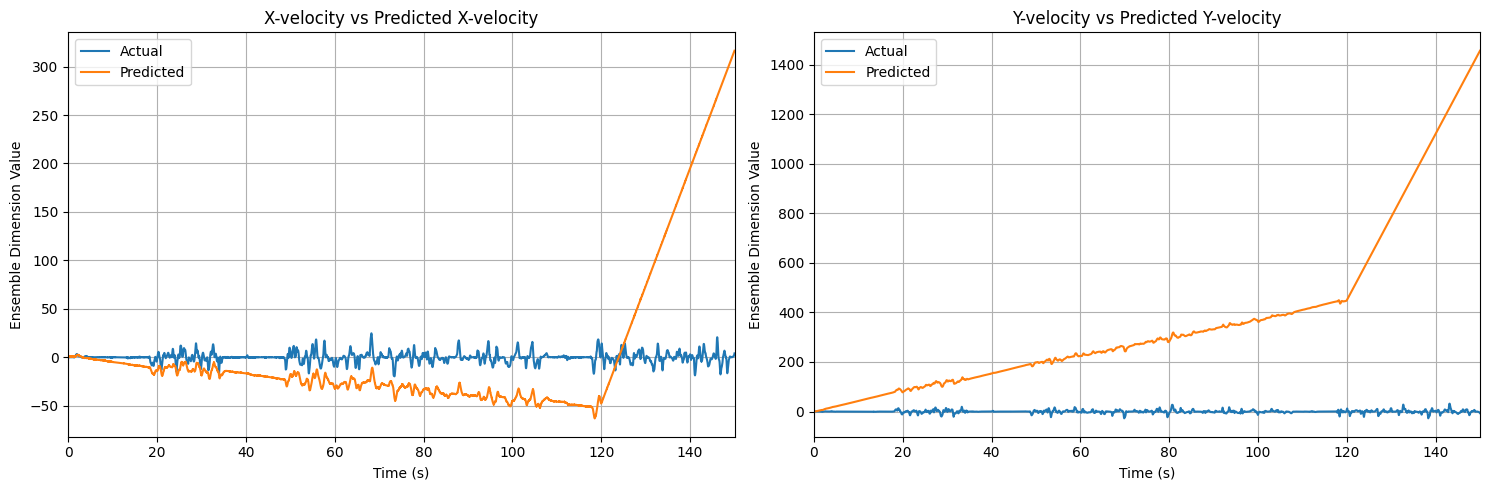

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(sim.trange(), true_vels[0])
ax1.plot(sim.trange(), pred_vels[0])
ax1.set_title("X-velocity vs Predicted X-velocity")
ax1.set_xlim((0,np.max(sim.trange())))
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Ensemble Dimension Value")
ax1.legend(["Actual", "Predicted"])
ax1.grid()

ax2.plot(sim.trange(), true_vels[1])
ax2.plot(sim.trange(), pred_vels[1])
ax2.set_title("Y-velocity vs Predicted Y-velocity")
ax2.set_xlim((0,np.max(sim.trange())))
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Ensemble Dimension Value")
ax2.legend(["Actual", "Predicted"])
ax2.grid()

fig.tight_layout()
plt.show()

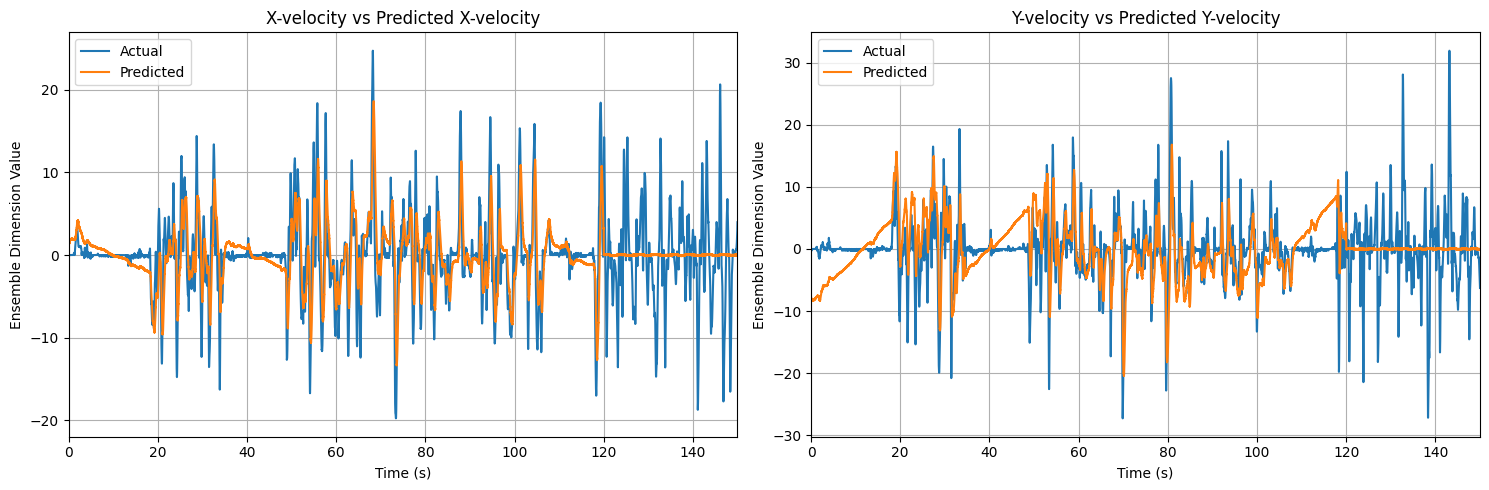

In [30]:
from scipy.signal import detrend

t_trainingstop = int(len(sim.trange())*0.8)-1
x_seg1 = detrend(pred_vels[0][:t_trainingstop])
x_seg2 = detrend(pred_vels[0][t_trainingstop:])
x_full = np.concatenate((x_seg1, x_seg2))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(sim.trange(), true_vels[0])
ax1.plot(sim.trange(), x_full)
ax1.set_title("X-velocity vs Predicted X-velocity")
ax1.set_xlim((0,np.max(sim.trange())))
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Ensemble Dimension Value")
ax1.legend(["Actual", "Predicted"])
ax1.grid()


y_seg1 = detrend(pred_vels[1][:t_trainingstop])
y_seg2 = detrend(pred_vels[1][t_trainingstop:])
y_full = np.concatenate((y_seg1, y_seg2))

ax2.plot(sim.trange(), true_vels[1])
ax2.plot(sim.trange(), y_full)
ax2.set_title("Y-velocity vs Predicted Y-velocity")
ax2.set_xlim((0,np.max(sim.trange())))
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Ensemble Dimension Value")
ax2.legend(["Actual", "Predicted"])
ax2.grid()

fig.tight_layout()
plt.show()
